In [1]:
from __future__ import print_function
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import ExponentialLR
from torch.optim.lr_scheduler import StepLR

In [3]:
from model import Net1, Net2
from train import train
from test import test
from config import ModelConfig

In [4]:
# View model config
args = ModelConfig()
args.dropout_value = 0.15
args.print_config()

Model Parameters:
{ 'batch_size_cpu': 64,
  'batch_size_cuda': 64,
  'dropout_value': 0.15,
  'epochs': 50,
  'num_workers': 4,
  'seed': 1}


In [5]:
transform = transforms.Compose(
    [#transforms.ToPILImage(),
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.ToTensor(),
     transforms.Normalize((0.4919, 0.4827, 0.4472), (0.2470, 0.2434, 0.2616)),
     #transforms.RandomAffine((-5,5), translate=(0.1,0.1), scale=(0.9,1.1), shear=None, resample=False, fill=(0.4919, 0.4827, 0.4472))
    ])

trainset = torchvision.datasets.CIFAR10(root='./../data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=args.batch_size_cuda,
                                          shuffle=True, num_workers=args.num_workers)

testset = torchvision.datasets.CIFAR10(root='./../data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=args.batch_size_cuda,
                                         shuffle=False, num_workers=args.num_workers)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

#dict to store model loss and accuracy parameters
history = {}

Files already downloaded and verified
Files already downloaded and verified
CUDA Available? True


torch.Size([64, 3, 32, 32])
 ship  bird   cat   dog


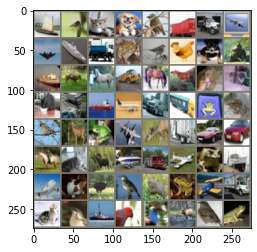

In [6]:
# functions to show an image

def imshow(img):
    #(0.4919, 0.4827, 0.4472), (0.2470, 0.2434, 0.2616)
    img[0] = img[0]*0.2470 + 0.4919
    img[1] = img[1]*0.2434 + 0.4827
    img[2] = img[2]*0.2616 + 0.4472
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [7]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [30, 12]

def training_curves(history):
  plt.figure(1)
  plt.suptitle("Combined Training Curves", fontsize=28)

  plt.subplot(2,2, 1)
  for i in history:
    plt.plot(np.array(history[i]['train_loss']), label=i)
  #plt.plot(np.array(hist_train_acc), 'r')
  plt.ylim(ymin=0)
  plt.ylabel('loss')
  plt.minorticks_on()
  plt.grid()
  plt.legend()
  plt.title("Training loss per batch")

  plt.subplot(2,2, 2)
  for i in history:
    plt.plot(np.array(history[i]['test_loss']), label=i)
  plt.ylim(ymin=0)
  plt.ylabel('loss')
  plt.minorticks_on()
  plt.grid()
  plt.legend()
  plt.title("Test loss per batch")

  plt.subplot(2,2, 3)
  for i in history:
    plt.plot(np.array(history[i]['train_accuracy']), label=i)
  plt.ylim(top=100)
  plt.xlabel('epochs')
  plt.ylabel('accuracy')
  plt.minorticks_on()
  plt.grid()
  plt.legend()
  plt.title("Training accuracy per batch")

  plt.subplot(2,2, 4)
  for i in history:
    plt.plot(np.array(history[i]['test_accuracy']), label=i)
  plt.ylim(top=100)
  plt.xlabel('epochs')
  plt.ylabel('accuracy')
  plt.minorticks_on()
  plt.grid()
  plt.legend()
  plt.title("Test accuracy per epoch")


In [8]:
temp = Net1(args).to(device)
summary(temp, 
        (3, 32, 32),)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           9,216
              ReLU-6           [-1, 32, 32, 32]               0
       BatchNorm2d-7           [-1, 32, 32, 32]              64
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 32, 16, 16]           9,216
             ReLU-10           [-1, 32, 16, 16]               0
      BatchNorm2d-11           [-1, 32, 16, 16]              64
          Dropout-12           [-1, 32, 16, 16]               0
           Conv2d-13           [-1, 32, 16, 16]           9,216
             ReLU-14           [-1, 32,

In [9]:
temp = Net2(args).to(device)
summary(temp, 
        (3, 32, 32),)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           9,216
              ReLU-6           [-1, 32, 32, 32]               0
       BatchNorm2d-7           [-1, 32, 32, 32]              64
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 32, 32, 32]           9,216
             ReLU-10           [-1, 32, 32, 32]               0
      BatchNorm2d-11           [-1, 32, 32, 32]              64
          Dropout-12           [-1, 32, 32, 32]               0
           Conv2d-13           [-1, 32, 16, 16]           9,216
             ReLU-14           [-1, 32,

In [10]:
# Input parameters for the model
EPOCHS = 100
l1_decay=0.000
l2_decay=0.0
#norm_type = "BN"
#num_groups=2
#input_img_size=(1, 28, 28)


# Run model for first 20 epochs with high rate, and half it thereafter
model = Net1(args).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=30, gamma=0.5)

# run_model(model, optimizer, scheduler, EPOCHS, l1=0.0, l2=0.0)

train_loss_list = []
train_accuracy_list = []
test_loss_list = []
test_accuracy_list = []
misclassified_imgs = []
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train_loss_list, train_accuracy_list = train(model, device, train_loader, criterion, optimizer, epoch, l1_decay, l2_decay, train_loss_list, train_accuracy_list)
    print("\nlearning rate", optimizer.param_groups[0]['lr'])
    scheduler.step()
    # test(model1, device, test_loader, test_losses, test_acc, misclassified_imgs, epoch==EPOCHS-1)
    test_loss_list, test_accuracy_list, misclassified_imgs = test(model, device, test_loader, criterion, classes, test_loss_list, test_accuracy_list, misclassified_imgs, epoch==EPOCHS-1)

name = 'Net1'
history[name] = {}
history[name]['train_loss'] = train_loss_list
history[name]['train_accuracy'] = train_accuracy_list
history[name]['test_loss'] = test_loss_list
history[name]['test_accuracy'] = test_accuracy_list
history[name]['misclassified_imgs'] = misclassified_imgs

  0%|          | 0/782 [00:00<?, ?it/s]

EPOCH: 1


Loss=2.3195877075195312 Batch_id=781 Accuracy=14.70: 100%|██████████| 782/782 [00:06<00:00, 126.39it/s]

length of Average loss 782, length of Average accuracy 782

learning rate 0.01



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0299, Accuracy: 2241/10000 (22.41%)

EPOCH: 2


Loss=1.7332763671875 Batch_id=781 Accuracy=31.27: 100%|██████████| 782/782 [00:06<00:00, 129.20it/s]   

length of Average loss 1564, length of Average accuracy 1564

learning rate 0.01



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0248, Accuracy: 4016/10000 (40.16%)

EPOCH: 3


Loss=1.4712930917739868 Batch_id=781 Accuracy=47.55: 100%|██████████| 782/782 [00:06<00:00, 127.32it/s]

length of Average loss 2346, length of Average accuracy 2346

learning rate 0.01



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0186, Accuracy: 5587/10000 (55.87%)

EPOCH: 4


Loss=1.2162418365478516 Batch_id=781 Accuracy=57.73: 100%|██████████| 782/782 [00:06<00:00, 128.22it/s]

length of Average loss 3128, length of Average accuracy 3128

learning rate 0.01



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0162, Accuracy: 6218/10000 (62.18%)

EPOCH: 5


Loss=1.1395599842071533 Batch_id=781 Accuracy=62.12: 100%|██████████| 782/782 [00:06<00:00, 128.91it/s]

length of Average loss 3910, length of Average accuracy 3910

learning rate 0.01



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0150, Accuracy: 6525/10000 (65.25%)

EPOCH: 6


Loss=1.4830931425094604 Batch_id=781 Accuracy=65.00: 100%|██████████| 782/782 [00:06<00:00, 128.50it/s]

length of Average loss 4692, length of Average accuracy 4692

learning rate 0.01



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0140, Accuracy: 6752/10000 (67.52%)

EPOCH: 7


Loss=1.2112839221954346 Batch_id=781 Accuracy=67.03: 100%|██████████| 782/782 [00:06<00:00, 127.06it/s]

length of Average loss 5474, length of Average accuracy 5474

learning rate 0.01



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0129, Accuracy: 7109/10000 (71.09%)

EPOCH: 8


Loss=1.1039361953735352 Batch_id=781 Accuracy=68.87: 100%|██████████| 782/782 [00:06<00:00, 128.29it/s]

length of Average loss 6256, length of Average accuracy 6256

learning rate 0.01



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0124, Accuracy: 7186/10000 (71.86%)

EPOCH: 9


Loss=0.5866031646728516 Batch_id=781 Accuracy=70.29: 100%|██████████| 782/782 [00:06<00:00, 129.56it/s]

length of Average loss 7038, length of Average accuracy 7038

learning rate 0.01



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0116, Accuracy: 7349/10000 (73.49%)

EPOCH: 10


Loss=0.8979804515838623 Batch_id=781 Accuracy=71.28: 100%|██████████| 782/782 [00:06<00:00, 128.90it/s] 

length of Average loss 7820, length of Average accuracy 7820

learning rate 0.01



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0117, Accuracy: 7374/10000 (73.74%)

EPOCH: 11


Loss=0.739107608795166 Batch_id=781 Accuracy=72.16: 100%|██████████| 782/782 [00:05<00:00, 132.73it/s]  

length of Average loss 8602, length of Average accuracy 8602

learning rate 0.01



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0115, Accuracy: 7437/10000 (74.37%)

EPOCH: 12


Loss=0.8675034046173096 Batch_id=781 Accuracy=73.17: 100%|██████████| 782/782 [00:05<00:00, 136.75it/s] 

length of Average loss 9384, length of Average accuracy 9384

learning rate 0.01



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0114, Accuracy: 7456/10000 (74.56%)

EPOCH: 13


Loss=0.5805304050445557 Batch_id=781 Accuracy=73.62: 100%|██████████| 782/782 [00:05<00:00, 136.23it/s] 

length of Average loss 10166, length of Average accuracy 10166

learning rate 0.01



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0105, Accuracy: 7678/10000 (76.78%)

EPOCH: 14


Loss=0.6823233366012573 Batch_id=781 Accuracy=74.23: 100%|██████████| 782/782 [00:05<00:00, 137.83it/s] 

length of Average loss 10948, length of Average accuracy 10948

learning rate 0.01



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0102, Accuracy: 7740/10000 (77.40%)

EPOCH: 15


Loss=0.5601863861083984 Batch_id=781 Accuracy=74.62: 100%|██████████| 782/782 [00:05<00:00, 134.32it/s] 

length of Average loss 11730, length of Average accuracy 11730

learning rate 0.01



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0102, Accuracy: 7684/10000 (76.84%)

EPOCH: 16


Loss=1.0603219270706177 Batch_id=781 Accuracy=75.37: 100%|██████████| 782/782 [00:05<00:00, 136.96it/s] 

length of Average loss 12512, length of Average accuracy 12512

learning rate 0.01



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0102, Accuracy: 7690/10000 (76.90%)

EPOCH: 17


Loss=0.669641375541687 Batch_id=781 Accuracy=75.61: 100%|██████████| 782/782 [00:05<00:00, 137.32it/s]  

length of Average loss 13294, length of Average accuracy 13294

learning rate 0.01



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0101, Accuracy: 7786/10000 (77.86%)

EPOCH: 18


Loss=0.5245606899261475 Batch_id=781 Accuracy=75.77: 100%|██████████| 782/782 [00:05<00:00, 134.86it/s] 

length of Average loss 14076, length of Average accuracy 14076

learning rate 0.01



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0097, Accuracy: 7825/10000 (78.25%)

EPOCH: 19


Loss=0.43684476613998413 Batch_id=781 Accuracy=76.27: 100%|██████████| 782/782 [00:05<00:00, 137.33it/s]

length of Average loss 14858, length of Average accuracy 14858

learning rate 0.01



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0096, Accuracy: 7852/10000 (78.52%)

EPOCH: 20


Loss=0.7120362520217896 Batch_id=781 Accuracy=76.47: 100%|██████████| 782/782 [00:05<00:00, 136.17it/s] 

length of Average loss 15640, length of Average accuracy 15640

learning rate 0.01



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0096, Accuracy: 7838/10000 (78.38%)

EPOCH: 21


Loss=0.7195552587509155 Batch_id=781 Accuracy=76.85: 100%|██████████| 782/782 [00:05<00:00, 135.05it/s] 

length of Average loss 16422, length of Average accuracy 16422

learning rate 0.01



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0095, Accuracy: 7899/10000 (78.99%)

EPOCH: 22


Loss=1.5587526559829712 Batch_id=781 Accuracy=77.24: 100%|██████████| 782/782 [00:05<00:00, 135.98it/s] 

length of Average loss 17204, length of Average accuracy 17204

learning rate 0.01



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0096, Accuracy: 7890/10000 (78.90%)

EPOCH: 23


Loss=0.3997698724269867 Batch_id=781 Accuracy=77.18: 100%|██████████| 782/782 [00:05<00:00, 135.94it/s] 

length of Average loss 17986, length of Average accuracy 17986

learning rate 0.01



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0096, Accuracy: 7842/10000 (78.42%)

EPOCH: 24


Loss=0.9226716756820679 Batch_id=781 Accuracy=77.49: 100%|██████████| 782/782 [00:05<00:00, 134.78it/s] 

length of Average loss 18768, length of Average accuracy 18768

learning rate 0.01



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0093, Accuracy: 7931/10000 (79.31%)

EPOCH: 25


Loss=0.7866995930671692 Batch_id=781 Accuracy=77.61: 100%|██████████| 782/782 [00:05<00:00, 136.98it/s] 

length of Average loss 19550, length of Average accuracy 19550

learning rate 0.01



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0092, Accuracy: 7954/10000 (79.54%)

EPOCH: 26


Loss=0.6517077684402466 Batch_id=781 Accuracy=77.81: 100%|██████████| 782/782 [00:05<00:00, 137.99it/s] 

length of Average loss 20332, length of Average accuracy 20332

learning rate 0.01



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0091, Accuracy: 7948/10000 (79.48%)

EPOCH: 27


Loss=0.7364926338195801 Batch_id=781 Accuracy=78.02: 100%|██████████| 782/782 [00:05<00:00, 136.09it/s] 

length of Average loss 21114, length of Average accuracy 21114

learning rate 0.01



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0092, Accuracy: 7957/10000 (79.57%)

EPOCH: 28


Loss=1.3170415163040161 Batch_id=781 Accuracy=78.23: 100%|██████████| 782/782 [00:05<00:00, 137.32it/s] 


length of Average loss 21896, length of Average accuracy 21896

learning rate 0.01


  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0089, Accuracy: 8012/10000 (80.12%)

EPOCH: 29


Loss=0.7803946733474731 Batch_id=781 Accuracy=78.55: 100%|██████████| 782/782 [00:05<00:00, 134.52it/s] 

length of Average loss 22678, length of Average accuracy 22678

learning rate 0.01



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0087, Accuracy: 8064/10000 (80.64%)

EPOCH: 30


Loss=0.5017648935317993 Batch_id=781 Accuracy=78.71: 100%|██████████| 782/782 [00:05<00:00, 133.62it/s] 

length of Average loss 23460, length of Average accuracy 23460

learning rate 0.01



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0088, Accuracy: 8034/10000 (80.34%)

EPOCH: 31


Loss=0.5141398310661316 Batch_id=781 Accuracy=79.66: 100%|██████████| 782/782 [00:05<00:00, 135.45it/s] 

length of Average loss 24242, length of Average accuracy 24242

learning rate 0.005



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0085, Accuracy: 8083/10000 (80.83%)

EPOCH: 32


Loss=0.614395022392273 Batch_id=781 Accuracy=80.15: 100%|██████████| 782/782 [00:05<00:00, 135.51it/s]  

length of Average loss 25024, length of Average accuracy 25024

learning rate 0.005



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0084, Accuracy: 8129/10000 (81.29%)

EPOCH: 33


Loss=0.420840859413147 Batch_id=781 Accuracy=80.08: 100%|██████████| 782/782 [00:05<00:00, 135.40it/s]  

length of Average loss 25806, length of Average accuracy 25806

learning rate 0.005



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0084, Accuracy: 8123/10000 (81.23%)

EPOCH: 34


Loss=0.44101524353027344 Batch_id=781 Accuracy=80.10: 100%|██████████| 782/782 [00:05<00:00, 134.34it/s]

length of Average loss 26588, length of Average accuracy 26588

learning rate 0.005



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0083, Accuracy: 8150/10000 (81.50%)

EPOCH: 35


Loss=0.6468632817268372 Batch_id=781 Accuracy=80.50: 100%|██████████| 782/782 [00:05<00:00, 136.24it/s] 

length of Average loss 27370, length of Average accuracy 27370

learning rate 0.005



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0083, Accuracy: 8164/10000 (81.64%)

EPOCH: 36


Loss=0.5393242835998535 Batch_id=781 Accuracy=80.63: 100%|██████████| 782/782 [00:05<00:00, 135.71it/s] 

length of Average loss 28152, length of Average accuracy 28152

learning rate 0.005



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0084, Accuracy: 8129/10000 (81.29%)

EPOCH: 37


Loss=0.6765977740287781 Batch_id=781 Accuracy=80.60: 100%|██████████| 782/782 [00:05<00:00, 136.20it/s] 


length of Average loss 28934, length of Average accuracy 28934

learning rate 0.005


  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0084, Accuracy: 8100/10000 (81.00%)

EPOCH: 38


Loss=0.9569721817970276 Batch_id=781 Accuracy=80.70: 100%|██████████| 782/782 [00:06<00:00, 130.04it/s] 

length of Average loss 29716, length of Average accuracy 29716

learning rate 0.005



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0082, Accuracy: 8166/10000 (81.66%)

EPOCH: 39


Loss=0.46914467215538025 Batch_id=781 Accuracy=80.74: 100%|██████████| 782/782 [00:06<00:00, 126.06it/s]


length of Average loss 30498, length of Average accuracy 30498

learning rate 0.005


  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0082, Accuracy: 8184/10000 (81.84%)

EPOCH: 40


Loss=0.27590128779411316 Batch_id=781 Accuracy=80.72: 100%|██████████| 782/782 [00:06<00:00, 127.11it/s]

length of Average loss 31280, length of Average accuracy 31280

learning rate 0.005



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0082, Accuracy: 8165/10000 (81.65%)

EPOCH: 41


Loss=0.655046284198761 Batch_id=781 Accuracy=80.89: 100%|██████████| 782/782 [00:06<00:00, 127.55it/s]  

length of Average loss 32062, length of Average accuracy 32062

learning rate 0.005



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0083, Accuracy: 8161/10000 (81.61%)

EPOCH: 42


Loss=0.39419791102409363 Batch_id=781 Accuracy=81.03: 100%|██████████| 782/782 [00:06<00:00, 127.01it/s]

length of Average loss 32844, length of Average accuracy 32844

learning rate 0.005



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0082, Accuracy: 8216/10000 (82.16%)

EPOCH: 43


Loss=0.673501193523407 Batch_id=781 Accuracy=80.99: 100%|██████████| 782/782 [00:06<00:00, 127.04it/s]  

length of Average loss 33626, length of Average accuracy 33626

learning rate 0.005



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0081, Accuracy: 8198/10000 (81.98%)

EPOCH: 44


Loss=0.5038915872573853 Batch_id=781 Accuracy=81.12: 100%|██████████| 782/782 [00:06<00:00, 128.25it/s] 

length of Average loss 34408, length of Average accuracy 34408

learning rate 0.005



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0080, Accuracy: 8245/10000 (82.45%)

EPOCH: 45


Loss=0.7473962306976318 Batch_id=781 Accuracy=81.07: 100%|██████████| 782/782 [00:06<00:00, 127.91it/s] 

length of Average loss 35190, length of Average accuracy 35190

learning rate 0.005



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0082, Accuracy: 8194/10000 (81.94%)

EPOCH: 46


Loss=0.4979068636894226 Batch_id=781 Accuracy=80.91: 100%|██████████| 782/782 [00:06<00:00, 128.42it/s] 

length of Average loss 35972, length of Average accuracy 35972

learning rate 0.005



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0081, Accuracy: 8203/10000 (82.03%)

EPOCH: 47


Loss=0.3059495687484741 Batch_id=781 Accuracy=81.44: 100%|██████████| 782/782 [00:06<00:00, 128.39it/s] 

length of Average loss 36754, length of Average accuracy 36754

learning rate 0.005



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0081, Accuracy: 8202/10000 (82.02%)

EPOCH: 48


Loss=0.40913116931915283 Batch_id=781 Accuracy=81.46: 100%|██████████| 782/782 [00:06<00:00, 127.71it/s]

length of Average loss 37536, length of Average accuracy 37536

learning rate 0.005



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0083, Accuracy: 8159/10000 (81.59%)

EPOCH: 49


Loss=0.39141497015953064 Batch_id=781 Accuracy=81.27: 100%|██████████| 782/782 [00:06<00:00, 128.30it/s]

length of Average loss 38318, length of Average accuracy 38318

learning rate 0.005



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0080, Accuracy: 8210/10000 (82.10%)

EPOCH: 50


Loss=0.594986081123352 Batch_id=781 Accuracy=81.36: 100%|██████████| 782/782 [00:06<00:00, 127.81it/s]  

length of Average loss 39100, length of Average accuracy 39100

learning rate 0.005



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0082, Accuracy: 8204/10000 (82.04%)

EPOCH: 51


Loss=0.7385128140449524 Batch_id=781 Accuracy=81.35: 100%|██████████| 782/782 [00:06<00:00, 129.43it/s] 

length of Average loss 39882, length of Average accuracy 39882

learning rate 0.005



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0080, Accuracy: 8249/10000 (82.49%)

EPOCH: 52


Loss=0.1723230481147766 Batch_id=781 Accuracy=81.66: 100%|██████████| 782/782 [00:06<00:00, 128.36it/s] 

length of Average loss 40664, length of Average accuracy 40664

learning rate 0.005



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0080, Accuracy: 8249/10000 (82.49%)

EPOCH: 53


Loss=0.19616331160068512 Batch_id=781 Accuracy=81.69: 100%|██████████| 782/782 [00:06<00:00, 127.32it/s]

length of Average loss 41446, length of Average accuracy 41446

learning rate 0.005



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0078, Accuracy: 8243/10000 (82.43%)

EPOCH: 54


Loss=0.8011401295661926 Batch_id=781 Accuracy=81.65: 100%|██████████| 782/782 [00:06<00:00, 127.92it/s] 

length of Average loss 42228, length of Average accuracy 42228

learning rate 0.005



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0081, Accuracy: 8207/10000 (82.07%)

EPOCH: 55


Loss=0.1738026887178421 Batch_id=781 Accuracy=81.75: 100%|██████████| 782/782 [00:06<00:00, 129.12it/s] 

length of Average loss 43010, length of Average accuracy 43010

learning rate 0.005



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0081, Accuracy: 8251/10000 (82.51%)

EPOCH: 56


Loss=0.8417229652404785 Batch_id=781 Accuracy=81.80: 100%|██████████| 782/782 [00:06<00:00, 128.49it/s] 

length of Average loss 43792, length of Average accuracy 43792

learning rate 0.005



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0080, Accuracy: 8240/10000 (82.40%)

EPOCH: 57


Loss=0.2917090654373169 Batch_id=781 Accuracy=81.81: 100%|██████████| 782/782 [00:06<00:00, 128.15it/s] 

length of Average loss 44574, length of Average accuracy 44574

learning rate 0.005



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0081, Accuracy: 8241/10000 (82.41%)

EPOCH: 58


Loss=0.17792882025241852 Batch_id=781 Accuracy=81.91: 100%|██████████| 782/782 [00:06<00:00, 129.43it/s]

length of Average loss 45356, length of Average accuracy 45356

learning rate 0.005



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0080, Accuracy: 8274/10000 (82.74%)

EPOCH: 59


Loss=1.062715768814087 Batch_id=781 Accuracy=81.81: 100%|██████████| 782/782 [00:06<00:00, 127.91it/s]  

length of Average loss 46138, length of Average accuracy 46138

learning rate 0.005



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0079, Accuracy: 8257/10000 (82.57%)

EPOCH: 60


Loss=1.0078682899475098 Batch_id=781 Accuracy=81.90: 100%|██████████| 782/782 [00:06<00:00, 129.40it/s] 


length of Average loss 46920, length of Average accuracy 46920

learning rate 0.005


  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0080, Accuracy: 8252/10000 (82.52%)

EPOCH: 61


Loss=0.30448824167251587 Batch_id=781 Accuracy=82.30: 100%|██████████| 782/782 [00:06<00:00, 129.25it/s]

length of Average loss 47702, length of Average accuracy 47702

learning rate 0.0025



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0077, Accuracy: 8266/10000 (82.66%)

EPOCH: 62


Loss=0.5983617901802063 Batch_id=781 Accuracy=82.49: 100%|██████████| 782/782 [00:06<00:00, 127.29it/s] 


length of Average loss 48484, length of Average accuracy 48484

learning rate 0.0025


  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0077, Accuracy: 8287/10000 (82.87%)

EPOCH: 63


Loss=0.37697240710258484 Batch_id=781 Accuracy=82.55: 100%|██████████| 782/782 [00:06<00:00, 126.70it/s]

length of Average loss 49266, length of Average accuracy 49266

learning rate 0.0025



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0079, Accuracy: 8282/10000 (82.82%)

EPOCH: 64


Loss=0.4652104079723358 Batch_id=781 Accuracy=82.87: 100%|██████████| 782/782 [00:06<00:00, 127.35it/s] 

length of Average loss 50048, length of Average accuracy 50048

learning rate 0.0025



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0077, Accuracy: 8332/10000 (83.32%)

EPOCH: 65


Loss=0.6873413920402527 Batch_id=781 Accuracy=82.63: 100%|██████████| 782/782 [00:06<00:00, 127.79it/s] 

length of Average loss 50830, length of Average accuracy 50830

learning rate 0.0025



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0078, Accuracy: 8290/10000 (82.90%)

EPOCH: 66


Loss=0.24213016033172607 Batch_id=781 Accuracy=82.59: 100%|██████████| 782/782 [00:06<00:00, 128.00it/s]

length of Average loss 51612, length of Average accuracy 51612

learning rate 0.0025



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0076, Accuracy: 8350/10000 (83.50%)

EPOCH: 67


Loss=0.5001215934753418 Batch_id=781 Accuracy=82.81: 100%|██████████| 782/782 [00:06<00:00, 127.38it/s] 

length of Average loss 52394, length of Average accuracy 52394

learning rate 0.0025



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0076, Accuracy: 8306/10000 (83.06%)

EPOCH: 68


Loss=0.6236410140991211 Batch_id=781 Accuracy=82.77: 100%|██████████| 782/782 [00:06<00:00, 126.44it/s] 

length of Average loss 53176, length of Average accuracy 53176

learning rate 0.0025



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0077, Accuracy: 8326/10000 (83.26%)

EPOCH: 69


Loss=0.8187057971954346 Batch_id=781 Accuracy=82.82: 100%|██████████| 782/782 [00:06<00:00, 128.02it/s] 

length of Average loss 53958, length of Average accuracy 53958

learning rate 0.0025



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0076, Accuracy: 8316/10000 (83.16%)

EPOCH: 70


Loss=0.35445651412010193 Batch_id=781 Accuracy=82.78: 100%|██████████| 782/782 [00:06<00:00, 129.31it/s]

length of Average loss 54740, length of Average accuracy 54740

learning rate 0.0025



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0076, Accuracy: 8328/10000 (83.28%)

EPOCH: 71


Loss=0.10964243113994598 Batch_id=781 Accuracy=82.77: 100%|██████████| 782/782 [00:06<00:00, 128.97it/s]

length of Average loss 55522, length of Average accuracy 55522

learning rate 0.0025



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0078, Accuracy: 8290/10000 (82.90%)

EPOCH: 72


Loss=0.6035650968551636 Batch_id=781 Accuracy=82.73: 100%|██████████| 782/782 [00:06<00:00, 128.33it/s] 

length of Average loss 56304, length of Average accuracy 56304

learning rate 0.0025



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0077, Accuracy: 8278/10000 (82.78%)

EPOCH: 73


Loss=0.6258413791656494 Batch_id=781 Accuracy=82.98: 100%|██████████| 782/782 [00:06<00:00, 129.16it/s] 

length of Average loss 57086, length of Average accuracy 57086

learning rate 0.0025



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0077, Accuracy: 8293/10000 (82.93%)

EPOCH: 74


Loss=1.119631052017212 Batch_id=781 Accuracy=83.25: 100%|██████████| 782/782 [00:06<00:00, 128.38it/s]  

length of Average loss 57868, length of Average accuracy 57868

learning rate 0.0025



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0076, Accuracy: 8320/10000 (83.20%)

EPOCH: 75


Loss=0.4247976839542389 Batch_id=781 Accuracy=83.06: 100%|██████████| 782/782 [00:06<00:00, 128.51it/s] 

length of Average loss 58650, length of Average accuracy 58650

learning rate 0.0025



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0076, Accuracy: 8333/10000 (83.33%)

EPOCH: 76


Loss=0.6712090373039246 Batch_id=781 Accuracy=82.98: 100%|██████████| 782/782 [00:06<00:00, 128.65it/s] 

length of Average loss 59432, length of Average accuracy 59432

learning rate 0.0025



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0076, Accuracy: 8339/10000 (83.39%)

EPOCH: 77


Loss=0.7187883853912354 Batch_id=781 Accuracy=82.96: 100%|██████████| 782/782 [00:06<00:00, 127.46it/s] 

length of Average loss 60214, length of Average accuracy 60214

learning rate 0.0025



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0077, Accuracy: 8305/10000 (83.05%)

EPOCH: 78


Loss=0.1939326375722885 Batch_id=781 Accuracy=83.02: 100%|██████████| 782/782 [00:06<00:00, 127.31it/s] 

length of Average loss 60996, length of Average accuracy 60996

learning rate 0.0025



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0076, Accuracy: 8349/10000 (83.49%)

EPOCH: 79


Loss=0.3474469780921936 Batch_id=781 Accuracy=83.14: 100%|██████████| 782/782 [00:06<00:00, 127.39it/s] 

length of Average loss 61778, length of Average accuracy 61778

learning rate 0.0025



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0076, Accuracy: 8343/10000 (83.43%)

EPOCH: 80


Loss=0.3475213348865509 Batch_id=781 Accuracy=83.08: 100%|██████████| 782/782 [00:06<00:00, 128.64it/s] 

length of Average loss 62560, length of Average accuracy 62560

learning rate 0.0025



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0076, Accuracy: 8321/10000 (83.21%)

EPOCH: 81


Loss=1.0884203910827637 Batch_id=781 Accuracy=82.95: 100%|██████████| 782/782 [00:06<00:00, 126.89it/s] 

length of Average loss 63342, length of Average accuracy 63342

learning rate 0.0025



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0077, Accuracy: 8298/10000 (82.98%)

EPOCH: 82


Loss=0.32523828744888306 Batch_id=781 Accuracy=82.99: 100%|██████████| 782/782 [00:06<00:00, 127.42it/s]

length of Average loss 64124, length of Average accuracy 64124

learning rate 0.0025



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0075, Accuracy: 8343/10000 (83.43%)

EPOCH: 83


Loss=0.3396608829498291 Batch_id=781 Accuracy=83.17: 100%|██████████| 782/782 [00:06<00:00, 126.83it/s] 


length of Average loss 64906, length of Average accuracy 64906

learning rate 0.0025


  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0075, Accuracy: 8344/10000 (83.44%)

EPOCH: 84


Loss=0.8212009072303772 Batch_id=781 Accuracy=83.20: 100%|██████████| 782/782 [00:06<00:00, 127.47it/s] 

length of Average loss 65688, length of Average accuracy 65688

learning rate 0.0025



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0076, Accuracy: 8325/10000 (83.25%)

EPOCH: 85


Loss=0.5200558304786682 Batch_id=781 Accuracy=83.08: 100%|██████████| 782/782 [00:06<00:00, 127.78it/s] 

length of Average loss 66470, length of Average accuracy 66470

learning rate 0.0025



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0075, Accuracy: 8364/10000 (83.64%)

EPOCH: 86


Loss=0.423881858587265 Batch_id=781 Accuracy=83.18: 100%|██████████| 782/782 [00:06<00:00, 127.90it/s]  

length of Average loss 67252, length of Average accuracy 67252

learning rate 0.0025



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0076, Accuracy: 8332/10000 (83.32%)

EPOCH: 87


Loss=1.0183658599853516 Batch_id=781 Accuracy=83.10: 100%|██████████| 782/782 [00:06<00:00, 127.36it/s] 


length of Average loss 68034, length of Average accuracy 68034

learning rate 0.0025


  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0077, Accuracy: 8315/10000 (83.15%)

EPOCH: 88


Loss=0.605875551700592 Batch_id=781 Accuracy=83.33: 100%|██████████| 782/782 [00:06<00:00, 128.72it/s]  

length of Average loss 68816, length of Average accuracy 68816

learning rate 0.0025



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0076, Accuracy: 8309/10000 (83.09%)

EPOCH: 89


Loss=0.6501691341400146 Batch_id=781 Accuracy=83.27: 100%|██████████| 782/782 [00:06<00:00, 126.23it/s] 

length of Average loss 69598, length of Average accuracy 69598

learning rate 0.0025



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0076, Accuracy: 8333/10000 (83.33%)

EPOCH: 90


Loss=0.3186083734035492 Batch_id=781 Accuracy=83.34: 100%|██████████| 782/782 [00:06<00:00, 127.24it/s] 

length of Average loss 70380, length of Average accuracy 70380

learning rate 0.0025



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0076, Accuracy: 8320/10000 (83.20%)

EPOCH: 91


Loss=0.6457847356796265 Batch_id=781 Accuracy=83.57: 100%|██████████| 782/782 [00:06<00:00, 127.16it/s] 

length of Average loss 71162, length of Average accuracy 71162

learning rate 0.00125



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0075, Accuracy: 8368/10000 (83.68%)

EPOCH: 92


Loss=0.4944206774234772 Batch_id=781 Accuracy=83.70: 100%|██████████| 782/782 [00:06<00:00, 126.40it/s] 

length of Average loss 71944, length of Average accuracy 71944

learning rate 0.00125



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0074, Accuracy: 8375/10000 (83.75%)

EPOCH: 93


Loss=0.4631498157978058 Batch_id=781 Accuracy=83.56: 100%|██████████| 782/782 [00:06<00:00, 127.07it/s] 

length of Average loss 72726, length of Average accuracy 72726

learning rate 0.00125



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0074, Accuracy: 8360/10000 (83.60%)

EPOCH: 94


Loss=0.4153897166252136 Batch_id=781 Accuracy=83.85: 100%|██████████| 782/782 [00:06<00:00, 127.56it/s] 

length of Average loss 73508, length of Average accuracy 73508

learning rate 0.00125



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0074, Accuracy: 8373/10000 (83.73%)

EPOCH: 95


Loss=0.9319109320640564 Batch_id=781 Accuracy=83.68: 100%|██████████| 782/782 [00:06<00:00, 127.10it/s] 

length of Average loss 74290, length of Average accuracy 74290

learning rate 0.00125



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0076, Accuracy: 8330/10000 (83.30%)

EPOCH: 96


Loss=0.3154835104942322 Batch_id=781 Accuracy=83.86: 100%|██████████| 782/782 [00:06<00:00, 128.88it/s] 

length of Average loss 75072, length of Average accuracy 75072

learning rate 0.00125



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0074, Accuracy: 8384/10000 (83.84%)

EPOCH: 97


Loss=0.5617854595184326 Batch_id=781 Accuracy=83.74: 100%|██████████| 782/782 [00:06<00:00, 124.92it/s] 

length of Average loss 75854, length of Average accuracy 75854

learning rate 0.00125



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0074, Accuracy: 8397/10000 (83.97%)

EPOCH: 98


Loss=0.3353636562824249 Batch_id=781 Accuracy=83.90: 100%|██████████| 782/782 [00:06<00:00, 128.77it/s] 

length of Average loss 76636, length of Average accuracy 76636

learning rate 0.00125



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0075, Accuracy: 8398/10000 (83.98%)

EPOCH: 99


Loss=0.627453088760376 Batch_id=781 Accuracy=83.76: 100%|██████████| 782/782 [00:06<00:00, 128.38it/s]  


length of Average loss 77418, length of Average accuracy 77418

learning rate 0.00125


  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0074, Accuracy: 8381/10000 (83.81%)

EPOCH: 100


Loss=0.778817892074585 Batch_id=781 Accuracy=83.74: 100%|██████████| 782/782 [00:06<00:00, 127.10it/s]  

length of Average loss 78200, length of Average accuracy 78200

learning rate 0.00125


Test set: Average loss: 0.0075, Accuracy: 8390/10000 (83.90%)



In [11]:
# Input parameters for the model
EPOCHS = 100
l1_decay=0.000
l2_decay=0.0
#norm_type = "BN"
#num_groups=2
#input_img_size=(1, 28, 28)


# Run model for first 20 epochs with high rate, and half it thereafter
model = Net2(args).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=30, gamma=0.5)

# run_model(model, optimizer, scheduler, EPOCHS, l1=0.0, l2=0.0)

train_loss_list = []
train_accuracy_list = []
test_loss_list = []
test_accuracy_list = []
misclassified_imgs = []
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train_loss_list, train_accuracy_list = train(model, device, train_loader, criterion, optimizer, epoch, l1_decay, l2_decay, train_loss_list, train_accuracy_list)
    print("\nlearning rate", optimizer.param_groups[0]['lr'])
    scheduler.step()
    # test(model1, device, test_loader, test_losses, test_acc, misclassified_imgs, epoch==EPOCHS-1)
    test_loss_list, test_accuracy_list, misclassified_imgs = test(model, device, test_loader, criterion, classes, test_loss_list, test_accuracy_list, misclassified_imgs, epoch==EPOCHS-1)

name = 'Net2'
history[name] = {}
history[name]['train_loss'] = train_loss_list
history[name]['train_accuracy'] = train_accuracy_list
history[name]['test_loss'] = test_loss_list
history[name]['test_accuracy'] = test_accuracy_list
history[name]['misclassified_imgs'] = misclassified_imgs

  0%|          | 0/782 [00:00<?, ?it/s]

EPOCH: 1


Loss=1.6925058364868164 Batch_id=781 Accuracy=40.53: 100%|██████████| 782/782 [00:08<00:00, 89.02it/s]

length of Average loss 782, length of Average accuracy 782

learning rate 0.01



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0217, Accuracy: 5040/10000 (50.40%)

EPOCH: 2


Loss=1.4158306121826172 Batch_id=781 Accuracy=54.17: 100%|██████████| 782/782 [00:08<00:00, 89.03it/s]

length of Average loss 1564, length of Average accuracy 1564

learning rate 0.01



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0175, Accuracy: 6060/10000 (60.60%)

EPOCH: 3


Loss=1.0276885032653809 Batch_id=781 Accuracy=60.72: 100%|██████████| 782/782 [00:08<00:00, 89.37it/s]

length of Average loss 2346, length of Average accuracy 2346

learning rate 0.01



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0153, Accuracy: 6499/10000 (64.99%)

EPOCH: 4


Loss=0.7838016748428345 Batch_id=781 Accuracy=65.19: 100%|██████████| 782/782 [00:08<00:00, 89.65it/s]

length of Average loss 3128, length of Average accuracy 3128

learning rate 0.01



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0132, Accuracy: 7033/10000 (70.33%)

EPOCH: 5


Loss=0.44016215205192566 Batch_id=781 Accuracy=67.83: 100%|██████████| 782/782 [00:08<00:00, 88.91it/s]

length of Average loss 3910, length of Average accuracy 3910

learning rate 0.01



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0124, Accuracy: 7182/10000 (71.82%)

EPOCH: 6


Loss=0.6142870783805847 Batch_id=781 Accuracy=69.89: 100%|██████████| 782/782 [00:08<00:00, 89.19it/s]

length of Average loss 4692, length of Average accuracy 4692

learning rate 0.01



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0117, Accuracy: 7348/10000 (73.48%)

EPOCH: 7


Loss=1.0932846069335938 Batch_id=781 Accuracy=71.47: 100%|██████████| 782/782 [00:08<00:00, 88.87it/s] 

length of Average loss 5474, length of Average accuracy 5474

learning rate 0.01



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0109, Accuracy: 7610/10000 (76.10%)

EPOCH: 8


Loss=0.7032452821731567 Batch_id=781 Accuracy=72.71: 100%|██████████| 782/782 [00:08<00:00, 89.26it/s] 

length of Average loss 6256, length of Average accuracy 6256

learning rate 0.01



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0109, Accuracy: 7595/10000 (75.95%)

EPOCH: 9


Loss=0.8162971138954163 Batch_id=781 Accuracy=73.52: 100%|██████████| 782/782 [00:08<00:00, 88.99it/s] 

length of Average loss 7038, length of Average accuracy 7038

learning rate 0.01



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0106, Accuracy: 7664/10000 (76.64%)

EPOCH: 10


Loss=1.0071630477905273 Batch_id=781 Accuracy=74.34: 100%|██████████| 782/782 [00:08<00:00, 89.25it/s] 

length of Average loss 7820, length of Average accuracy 7820

learning rate 0.01



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0103, Accuracy: 7736/10000 (77.36%)

EPOCH: 11


Loss=0.9134588241577148 Batch_id=781 Accuracy=75.25: 100%|██████████| 782/782 [00:08<00:00, 89.46it/s] 


length of Average loss 8602, length of Average accuracy 8602

learning rate 0.01


  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0099, Accuracy: 7760/10000 (77.60%)

EPOCH: 12


Loss=0.5275059938430786 Batch_id=781 Accuracy=75.78: 100%|██████████| 782/782 [00:08<00:00, 89.23it/s] 


length of Average loss 9384, length of Average accuracy 9384

learning rate 0.01


  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0097, Accuracy: 7853/10000 (78.53%)

EPOCH: 13


Loss=1.3583714962005615 Batch_id=781 Accuracy=76.36: 100%|██████████| 782/782 [00:08<00:00, 89.64it/s] 

length of Average loss 10166, length of Average accuracy 10166

learning rate 0.01



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0093, Accuracy: 7994/10000 (79.94%)

EPOCH: 14


Loss=1.1768132448196411 Batch_id=781 Accuracy=76.65: 100%|██████████| 782/782 [00:08<00:00, 89.70it/s] 

length of Average loss 10948, length of Average accuracy 10948

learning rate 0.01



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0094, Accuracy: 7927/10000 (79.27%)

EPOCH: 15


Loss=0.6735398173332214 Batch_id=781 Accuracy=77.12: 100%|██████████| 782/782 [00:08<00:00, 89.01it/s] 

length of Average loss 11730, length of Average accuracy 11730

learning rate 0.01



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0094, Accuracy: 7958/10000 (79.58%)

EPOCH: 16


Loss=0.509894847869873 Batch_id=781 Accuracy=77.68: 100%|██████████| 782/782 [00:08<00:00, 89.59it/s]  

length of Average loss 12512, length of Average accuracy 12512

learning rate 0.01



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0090, Accuracy: 7998/10000 (79.98%)

EPOCH: 17


Loss=0.5685654878616333 Batch_id=781 Accuracy=77.94: 100%|██████████| 782/782 [00:08<00:00, 88.74it/s] 


length of Average loss 13294, length of Average accuracy 13294

learning rate 0.01


  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0089, Accuracy: 8049/10000 (80.49%)

EPOCH: 18


Loss=0.24880461394786835 Batch_id=781 Accuracy=78.05: 100%|██████████| 782/782 [00:08<00:00, 89.44it/s]

length of Average loss 14076, length of Average accuracy 14076

learning rate 0.01



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0090, Accuracy: 8060/10000 (80.60%)

EPOCH: 19


Loss=0.45873895287513733 Batch_id=781 Accuracy=78.42: 100%|██████████| 782/782 [00:08<00:00, 89.84it/s]


length of Average loss 14858, length of Average accuracy 14858

learning rate 0.01


  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0087, Accuracy: 8059/10000 (80.59%)

EPOCH: 20


Loss=1.1981850862503052 Batch_id=781 Accuracy=78.83: 100%|██████████| 782/782 [00:08<00:00, 89.21it/s] 

length of Average loss 15640, length of Average accuracy 15640

learning rate 0.01



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0087, Accuracy: 8071/10000 (80.71%)

EPOCH: 21


Loss=0.8472274541854858 Batch_id=781 Accuracy=79.15: 100%|██████████| 782/782 [00:08<00:00, 89.07it/s] 

length of Average loss 16422, length of Average accuracy 16422

learning rate 0.01



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0084, Accuracy: 8169/10000 (81.69%)

EPOCH: 22


Loss=0.5228772759437561 Batch_id=781 Accuracy=79.37: 100%|██████████| 782/782 [00:08<00:00, 89.66it/s] 

length of Average loss 17204, length of Average accuracy 17204

learning rate 0.01



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0085, Accuracy: 8147/10000 (81.47%)

EPOCH: 23


Loss=1.0609426498413086 Batch_id=781 Accuracy=79.53: 100%|██████████| 782/782 [00:08<00:00, 89.94it/s] 


length of Average loss 17986, length of Average accuracy 17986

learning rate 0.01


  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0084, Accuracy: 8179/10000 (81.79%)

EPOCH: 24


Loss=0.5470208525657654 Batch_id=781 Accuracy=79.79: 100%|██████████| 782/782 [00:08<00:00, 89.18it/s] 

length of Average loss 18768, length of Average accuracy 18768

learning rate 0.01



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0085, Accuracy: 8142/10000 (81.42%)

EPOCH: 25


Loss=0.7582279443740845 Batch_id=781 Accuracy=79.95: 100%|██████████| 782/782 [00:08<00:00, 89.40it/s] 


length of Average loss 19550, length of Average accuracy 19550

learning rate 0.01


  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0082, Accuracy: 8191/10000 (81.91%)

EPOCH: 26


Loss=0.8415353894233704 Batch_id=781 Accuracy=80.16: 100%|██████████| 782/782 [00:08<00:00, 89.18it/s] 

length of Average loss 20332, length of Average accuracy 20332

learning rate 0.01



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0082, Accuracy: 8201/10000 (82.01%)

EPOCH: 27


Loss=0.750026285648346 Batch_id=781 Accuracy=80.32: 100%|██████████| 782/782 [00:08<00:00, 89.39it/s]  

length of Average loss 21114, length of Average accuracy 21114

learning rate 0.01



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0080, Accuracy: 8241/10000 (82.41%)

EPOCH: 28


Loss=0.6006636023521423 Batch_id=781 Accuracy=80.59: 100%|██████████| 782/782 [00:08<00:00, 89.15it/s] 

length of Average loss 21896, length of Average accuracy 21896

learning rate 0.01



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0083, Accuracy: 8225/10000 (82.25%)

EPOCH: 29


Loss=0.7946124076843262 Batch_id=781 Accuracy=80.58: 100%|██████████| 782/782 [00:08<00:00, 89.51it/s] 

length of Average loss 22678, length of Average accuracy 22678

learning rate 0.01



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0081, Accuracy: 8220/10000 (82.20%)

EPOCH: 30


Loss=0.3529891073703766 Batch_id=781 Accuracy=80.90: 100%|██████████| 782/782 [00:08<00:00, 89.42it/s] 

length of Average loss 23460, length of Average accuracy 23460

learning rate 0.01



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0080, Accuracy: 8260/10000 (82.60%)

EPOCH: 31


Loss=0.47041141986846924 Batch_id=781 Accuracy=82.00: 100%|██████████| 782/782 [00:08<00:00, 89.44it/s]


length of Average loss 24242, length of Average accuracy 24242

learning rate 0.005


  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0075, Accuracy: 8344/10000 (83.44%)

EPOCH: 32


Loss=0.6585610508918762 Batch_id=781 Accuracy=82.25: 100%|██████████| 782/782 [00:08<00:00, 89.16it/s] 


length of Average loss 25024, length of Average accuracy 25024

learning rate 0.005


  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0073, Accuracy: 8433/10000 (84.33%)

EPOCH: 33


Loss=0.6190121173858643 Batch_id=781 Accuracy=82.24: 100%|██████████| 782/782 [00:08<00:00, 89.30it/s] 

length of Average loss 25806, length of Average accuracy 25806

learning rate 0.005



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0074, Accuracy: 8368/10000 (83.68%)

EPOCH: 34


Loss=0.777772068977356 Batch_id=781 Accuracy=82.58: 100%|██████████| 782/782 [00:08<00:00, 89.31it/s]  

length of Average loss 26588, length of Average accuracy 26588

learning rate 0.005



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0074, Accuracy: 8371/10000 (83.71%)

EPOCH: 35


Loss=0.9282374978065491 Batch_id=781 Accuracy=82.41: 100%|██████████| 782/782 [00:08<00:00, 89.55it/s] 


length of Average loss 27370, length of Average accuracy 27370

learning rate 0.005


  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0075, Accuracy: 8361/10000 (83.61%)

EPOCH: 36


Loss=0.47829729318618774 Batch_id=781 Accuracy=82.61: 100%|██████████| 782/782 [00:08<00:00, 89.08it/s]

length of Average loss 28152, length of Average accuracy 28152

learning rate 0.005



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0074, Accuracy: 8402/10000 (84.02%)

EPOCH: 37


Loss=0.38326653838157654 Batch_id=781 Accuracy=82.82: 100%|██████████| 782/782 [00:08<00:00, 89.18it/s]

length of Average loss 28934, length of Average accuracy 28934

learning rate 0.005



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0073, Accuracy: 8426/10000 (84.26%)

EPOCH: 38


Loss=1.0340393781661987 Batch_id=781 Accuracy=82.94: 100%|██████████| 782/782 [00:08<00:00, 89.34it/s] 


length of Average loss 29716, length of Average accuracy 29716

learning rate 0.005


  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0073, Accuracy: 8430/10000 (84.30%)

EPOCH: 39


Loss=0.3100350797176361 Batch_id=781 Accuracy=83.09: 100%|██████████| 782/782 [00:08<00:00, 89.83it/s] 

length of Average loss 30498, length of Average accuracy 30498

learning rate 0.005



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0073, Accuracy: 8397/10000 (83.97%)

EPOCH: 40


Loss=0.3972773551940918 Batch_id=781 Accuracy=82.95: 100%|██████████| 782/782 [00:08<00:00, 88.96it/s] 

length of Average loss 31280, length of Average accuracy 31280

learning rate 0.005



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0074, Accuracy: 8385/10000 (83.85%)

EPOCH: 41


Loss=0.5682728290557861 Batch_id=781 Accuracy=83.07: 100%|██████████| 782/782 [00:08<00:00, 89.66it/s] 


length of Average loss 32062, length of Average accuracy 32062

learning rate 0.005


  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0072, Accuracy: 8459/10000 (84.59%)

EPOCH: 42


Loss=0.8788135051727295 Batch_id=781 Accuracy=83.29: 100%|██████████| 782/782 [00:08<00:00, 89.24it/s] 


length of Average loss 32844, length of Average accuracy 32844

learning rate 0.005


  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0072, Accuracy: 8432/10000 (84.32%)

EPOCH: 43


Loss=1.186216115951538 Batch_id=781 Accuracy=83.16: 100%|██████████| 782/782 [00:08<00:00, 89.31it/s]  

length of Average loss 33626, length of Average accuracy 33626

learning rate 0.005



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0073, Accuracy: 8443/10000 (84.43%)

EPOCH: 44


Loss=0.3659002184867859 Batch_id=781 Accuracy=83.35: 100%|██████████| 782/782 [00:08<00:00, 89.02it/s] 


length of Average loss 34408, length of Average accuracy 34408

learning rate 0.005


  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0073, Accuracy: 8396/10000 (83.96%)

EPOCH: 45


Loss=0.39859288930892944 Batch_id=781 Accuracy=83.30: 100%|██████████| 782/782 [00:08<00:00, 89.25it/s]

length of Average loss 35190, length of Average accuracy 35190

learning rate 0.005



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0071, Accuracy: 8443/10000 (84.43%)

EPOCH: 46


Loss=0.3081108033657074 Batch_id=781 Accuracy=83.43: 100%|██████████| 782/782 [00:08<00:00, 89.94it/s] 

length of Average loss 35972, length of Average accuracy 35972

learning rate 0.005



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0073, Accuracy: 8425/10000 (84.25%)

EPOCH: 47


Loss=0.5018485188484192 Batch_id=781 Accuracy=83.22: 100%|██████████| 782/782 [00:08<00:00, 89.46it/s] 

length of Average loss 36754, length of Average accuracy 36754

learning rate 0.005



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0072, Accuracy: 8418/10000 (84.18%)

EPOCH: 48


Loss=0.483193039894104 Batch_id=781 Accuracy=83.41: 100%|██████████| 782/782 [00:08<00:00, 89.74it/s]  

length of Average loss 37536, length of Average accuracy 37536

learning rate 0.005



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0071, Accuracy: 8460/10000 (84.60%)

EPOCH: 49


Loss=0.5090900659561157 Batch_id=781 Accuracy=83.27: 100%|██████████| 782/782 [00:08<00:00, 88.69it/s] 

length of Average loss 38318, length of Average accuracy 38318

learning rate 0.005



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0072, Accuracy: 8449/10000 (84.49%)

EPOCH: 50


Loss=0.7337291836738586 Batch_id=781 Accuracy=83.61: 100%|██████████| 782/782 [00:08<00:00, 89.76it/s] 

length of Average loss 39100, length of Average accuracy 39100

learning rate 0.005



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0073, Accuracy: 8444/10000 (84.44%)

EPOCH: 51


Loss=0.4768255352973938 Batch_id=781 Accuracy=83.33: 100%|██████████| 782/782 [00:08<00:00, 89.23it/s] 

length of Average loss 39882, length of Average accuracy 39882

learning rate 0.005



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0072, Accuracy: 8426/10000 (84.26%)

EPOCH: 52


Loss=0.43009573221206665 Batch_id=781 Accuracy=83.61: 100%|██████████| 782/782 [00:08<00:00, 89.39it/s]

length of Average loss 40664, length of Average accuracy 40664

learning rate 0.005



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0072, Accuracy: 8470/10000 (84.70%)

EPOCH: 53


Loss=0.31700262427330017 Batch_id=781 Accuracy=83.71: 100%|██████████| 782/782 [00:08<00:00, 90.05it/s]

length of Average loss 41446, length of Average accuracy 41446

learning rate 0.005



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0071, Accuracy: 8457/10000 (84.57%)

EPOCH: 54


Loss=0.334579199552536 Batch_id=781 Accuracy=83.73: 100%|██████████| 782/782 [00:08<00:00, 88.52it/s]  


length of Average loss 42228, length of Average accuracy 42228

learning rate 0.005


  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0071, Accuracy: 8430/10000 (84.30%)

EPOCH: 55


Loss=0.43664664030075073 Batch_id=781 Accuracy=83.67: 100%|██████████| 782/782 [00:08<00:00, 89.17it/s]

length of Average loss 43010, length of Average accuracy 43010

learning rate 0.005



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0071, Accuracy: 8464/10000 (84.64%)

EPOCH: 56


Loss=0.26514410972595215 Batch_id=781 Accuracy=83.79: 100%|██████████| 782/782 [00:08<00:00, 89.16it/s]

length of Average loss 43792, length of Average accuracy 43792

learning rate 0.005



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0071, Accuracy: 8445/10000 (84.45%)

EPOCH: 57


Loss=0.33577868342399597 Batch_id=781 Accuracy=83.68: 100%|██████████| 782/782 [00:08<00:00, 88.90it/s]

length of Average loss 44574, length of Average accuracy 44574

learning rate 0.005



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0070, Accuracy: 8494/10000 (84.94%)

EPOCH: 58


Loss=0.3486417233943939 Batch_id=781 Accuracy=83.72: 100%|██████████| 782/782 [00:08<00:00, 89.22it/s] 

length of Average loss 45356, length of Average accuracy 45356

learning rate 0.005



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0070, Accuracy: 8466/10000 (84.66%)

EPOCH: 59


Loss=1.3347108364105225 Batch_id=781 Accuracy=83.74: 100%|██████████| 782/782 [00:08<00:00, 89.60it/s] 

length of Average loss 46138, length of Average accuracy 46138

learning rate 0.005



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0070, Accuracy: 8495/10000 (84.95%)

EPOCH: 60


Loss=0.28668680787086487 Batch_id=781 Accuracy=84.07: 100%|██████████| 782/782 [00:08<00:00, 89.46it/s]

length of Average loss 46920, length of Average accuracy 46920

learning rate 0.005



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0070, Accuracy: 8494/10000 (84.94%)

EPOCH: 61


Loss=0.5487139821052551 Batch_id=781 Accuracy=84.59: 100%|██████████| 782/782 [00:08<00:00, 89.54it/s] 


length of Average loss 47702, length of Average accuracy 47702

learning rate 0.0025


  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 92 %
Accuracy of   car : 92 %
Accuracy of  bird : 82 %
Accuracy of   cat : 64 %
Accuracy of  deer : 87 %
Accuracy of   dog : 76 %
Accuracy of  frog : 91 %
Accuracy of horse : 89 %
Accuracy of  ship : 91 %
Accuracy of truck : 93 %

Test set: Average loss: 0.0069, Accuracy: 8511/10000 (85.11%)

EPOCH: 62


Loss=0.5764362215995789 Batch_id=781 Accuracy=84.53: 100%|██████████| 782/782 [00:08<00:00, 89.16it/s] 

length of Average loss 48484, length of Average accuracy 48484

learning rate 0.0025



  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 92 %
Accuracy of   car : 96 %
Accuracy of  bird : 82 %
Accuracy of   cat : 68 %
Accuracy of  deer : 81 %
Accuracy of   dog : 77 %
Accuracy of  frog : 92 %
Accuracy of horse : 90 %
Accuracy of  ship : 93 %
Accuracy of truck : 92 %

Test set: Average loss: 0.0069, Accuracy: 8534/10000 (85.34%)

EPOCH: 63


Loss=1.029435396194458 Batch_id=781 Accuracy=84.82: 100%|██████████| 782/782 [00:08<00:00, 89.49it/s]  

length of Average loss 49266, length of Average accuracy 49266

learning rate 0.0025



  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 92 %
Accuracy of   car : 92 %
Accuracy of  bird : 75 %
Accuracy of   cat : 71 %
Accuracy of  deer : 85 %
Accuracy of   dog : 77 %
Accuracy of  frog : 87 %
Accuracy of horse : 87 %
Accuracy of  ship : 93 %
Accuracy of truck : 92 %

Test set: Average loss: 0.0069, Accuracy: 8505/10000 (85.05%)

EPOCH: 64


Loss=0.31136685609817505 Batch_id=781 Accuracy=84.59: 100%|██████████| 782/782 [00:08<00:00, 89.24it/s]


length of Average loss 50048, length of Average accuracy 50048

learning rate 0.0025


  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 91 %
Accuracy of   car : 92 %
Accuracy of  bird : 81 %
Accuracy of   cat : 61 %
Accuracy of  deer : 85 %
Accuracy of   dog : 79 %
Accuracy of  frog : 91 %
Accuracy of horse : 89 %
Accuracy of  ship : 91 %
Accuracy of truck : 92 %

Test set: Average loss: 0.0067, Accuracy: 8565/10000 (85.65%)

EPOCH: 65


Loss=0.6108967065811157 Batch_id=781 Accuracy=84.78: 100%|██████████| 782/782 [00:08<00:00, 89.74it/s] 


length of Average loss 50830, length of Average accuracy 50830

learning rate 0.0025


  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 89 %
Accuracy of   car : 94 %
Accuracy of  bird : 82 %
Accuracy of   cat : 64 %
Accuracy of  deer : 83 %
Accuracy of   dog : 83 %
Accuracy of  frog : 85 %
Accuracy of horse : 87 %
Accuracy of  ship : 91 %
Accuracy of truck : 89 %

Test set: Average loss: 0.0069, Accuracy: 8523/10000 (85.23%)

EPOCH: 66


Loss=0.7072536945343018 Batch_id=781 Accuracy=84.73: 100%|██████████| 782/782 [00:08<00:00, 89.26it/s] 

length of Average loss 51612, length of Average accuracy 51612

learning rate 0.0025



  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 89 %
Accuracy of   car : 92 %
Accuracy of  bird : 79 %
Accuracy of   cat : 61 %
Accuracy of  deer : 87 %
Accuracy of   dog : 81 %
Accuracy of  frog : 91 %
Accuracy of horse : 89 %
Accuracy of  ship : 91 %
Accuracy of truck : 92 %

Test set: Average loss: 0.0068, Accuracy: 8549/10000 (85.49%)

EPOCH: 67


Loss=0.3434978425502777 Batch_id=781 Accuracy=84.75: 100%|██████████| 782/782 [00:08<00:00, 88.57it/s] 

length of Average loss 52394, length of Average accuracy 52394

learning rate 0.0025



  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 92 %
Accuracy of   car : 96 %
Accuracy of  bird : 78 %
Accuracy of   cat : 71 %
Accuracy of  deer : 81 %
Accuracy of   dog : 77 %
Accuracy of  frog : 89 %
Accuracy of horse : 82 %
Accuracy of  ship : 91 %
Accuracy of truck : 91 %

Test set: Average loss: 0.0068, Accuracy: 8542/10000 (85.42%)

EPOCH: 68


Loss=0.6208645105361938 Batch_id=781 Accuracy=84.74: 100%|██████████| 782/782 [00:08<00:00, 90.64it/s] 

length of Average loss 53176, length of Average accuracy 53176

learning rate 0.0025



  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 89 %
Accuracy of   car : 94 %
Accuracy of  bird : 79 %
Accuracy of   cat : 68 %
Accuracy of  deer : 81 %
Accuracy of   dog : 77 %
Accuracy of  frog : 91 %
Accuracy of horse : 85 %
Accuracy of  ship : 93 %
Accuracy of truck : 92 %

Test set: Average loss: 0.0068, Accuracy: 8527/10000 (85.27%)

EPOCH: 69


Loss=0.3635936379432678 Batch_id=781 Accuracy=84.95: 100%|██████████| 782/782 [00:08<00:00, 95.41it/s] 

length of Average loss 53958, length of Average accuracy 53958

learning rate 0.0025



  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 92 %
Accuracy of   car : 96 %
Accuracy of  bird : 77 %
Accuracy of   cat : 65 %
Accuracy of  deer : 81 %
Accuracy of   dog : 76 %
Accuracy of  frog : 92 %
Accuracy of horse : 89 %
Accuracy of  ship : 91 %
Accuracy of truck : 91 %

Test set: Average loss: 0.0068, Accuracy: 8567/10000 (85.67%)

EPOCH: 70


Loss=0.2675744295120239 Batch_id=781 Accuracy=84.91: 100%|██████████| 782/782 [00:08<00:00, 94.23it/s] 

length of Average loss 54740, length of Average accuracy 54740

learning rate 0.0025



  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 92 %
Accuracy of   car : 94 %
Accuracy of  bird : 81 %
Accuracy of   cat : 64 %
Accuracy of  deer : 85 %
Accuracy of   dog : 76 %
Accuracy of  frog : 89 %
Accuracy of horse : 90 %
Accuracy of  ship : 91 %
Accuracy of truck : 93 %

Test set: Average loss: 0.0068, Accuracy: 8546/10000 (85.46%)

EPOCH: 71


Loss=0.18433627486228943 Batch_id=781 Accuracy=85.07: 100%|██████████| 782/782 [00:08<00:00, 94.36it/s]

length of Average loss 55522, length of Average accuracy 55522

learning rate 0.0025



  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 89 %
Accuracy of   car : 94 %
Accuracy of  bird : 72 %
Accuracy of   cat : 73 %
Accuracy of  deer : 81 %
Accuracy of   dog : 76 %
Accuracy of  frog : 94 %
Accuracy of horse : 85 %
Accuracy of  ship : 93 %
Accuracy of truck : 93 %

Test set: Average loss: 0.0067, Accuracy: 8561/10000 (85.61%)

EPOCH: 72


Loss=0.5881376266479492 Batch_id=781 Accuracy=84.97: 100%|██████████| 782/782 [00:08<00:00, 94.66it/s] 

length of Average loss 56304, length of Average accuracy 56304

learning rate 0.0025



  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 91 %
Accuracy of   car : 94 %
Accuracy of  bird : 81 %
Accuracy of   cat : 68 %
Accuracy of  deer : 83 %
Accuracy of   dog : 77 %
Accuracy of  frog : 94 %
Accuracy of horse : 89 %
Accuracy of  ship : 94 %
Accuracy of truck : 93 %

Test set: Average loss: 0.0069, Accuracy: 8525/10000 (85.25%)

EPOCH: 73


Loss=0.3120209872722626 Batch_id=781 Accuracy=85.12: 100%|██████████| 782/782 [00:08<00:00, 94.38it/s] 

length of Average loss 57086, length of Average accuracy 57086

learning rate 0.0025



  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 91 %
Accuracy of   car : 94 %
Accuracy of  bird : 82 %
Accuracy of   cat : 61 %
Accuracy of  deer : 83 %
Accuracy of   dog : 79 %
Accuracy of  frog : 94 %
Accuracy of horse : 85 %
Accuracy of  ship : 94 %
Accuracy of truck : 93 %

Test set: Average loss: 0.0069, Accuracy: 8531/10000 (85.31%)

EPOCH: 74


Loss=0.593345582485199 Batch_id=781 Accuracy=85.10: 100%|██████████| 782/782 [00:08<00:00, 94.69it/s]  

length of Average loss 57868, length of Average accuracy 57868

learning rate 0.0025



  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 91 %
Accuracy of   car : 96 %
Accuracy of  bird : 81 %
Accuracy of   cat : 63 %
Accuracy of  deer : 83 %
Accuracy of   dog : 79 %
Accuracy of  frog : 94 %
Accuracy of horse : 89 %
Accuracy of  ship : 91 %
Accuracy of truck : 92 %

Test set: Average loss: 0.0068, Accuracy: 8522/10000 (85.22%)

EPOCH: 75


Loss=0.29244279861450195 Batch_id=781 Accuracy=85.14: 100%|██████████| 782/782 [00:08<00:00, 95.02it/s]

length of Average loss 58650, length of Average accuracy 58650

learning rate 0.0025



  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 87 %
Accuracy of   car : 96 %
Accuracy of  bird : 77 %
Accuracy of   cat : 67 %
Accuracy of  deer : 81 %
Accuracy of   dog : 74 %
Accuracy of  frog : 89 %
Accuracy of horse : 89 %
Accuracy of  ship : 94 %
Accuracy of truck : 92 %

Test set: Average loss: 0.0067, Accuracy: 8572/10000 (85.72%)

EPOCH: 76


Loss=0.29492151737213135 Batch_id=781 Accuracy=85.12: 100%|██████████| 782/782 [00:08<00:00, 94.89it/s]

length of Average loss 59432, length of Average accuracy 59432

learning rate 0.0025



  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 92 %
Accuracy of   car : 96 %
Accuracy of  bird : 75 %
Accuracy of   cat : 68 %
Accuracy of  deer : 80 %
Accuracy of   dog : 76 %
Accuracy of  frog : 89 %
Accuracy of horse : 87 %
Accuracy of  ship : 93 %
Accuracy of truck : 93 %

Test set: Average loss: 0.0067, Accuracy: 8559/10000 (85.59%)

EPOCH: 77


Loss=0.5823056697845459 Batch_id=781 Accuracy=85.16: 100%|██████████| 782/782 [00:08<00:00, 94.70it/s] 

length of Average loss 60214, length of Average accuracy 60214

learning rate 0.0025



  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 92 %
Accuracy of   car : 96 %
Accuracy of  bird : 84 %
Accuracy of   cat : 68 %
Accuracy of  deer : 83 %
Accuracy of   dog : 76 %
Accuracy of  frog : 91 %
Accuracy of horse : 87 %
Accuracy of  ship : 94 %
Accuracy of truck : 91 %

Test set: Average loss: 0.0067, Accuracy: 8555/10000 (85.55%)

EPOCH: 78


Loss=0.39826950430870056 Batch_id=781 Accuracy=85.06: 100%|██████████| 782/782 [00:08<00:00, 94.35it/s]

length of Average loss 60996, length of Average accuracy 60996

learning rate 0.0025



  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 92 %
Accuracy of   car : 96 %
Accuracy of  bird : 73 %
Accuracy of   cat : 67 %
Accuracy of  deer : 83 %
Accuracy of   dog : 77 %
Accuracy of  frog : 92 %
Accuracy of horse : 85 %
Accuracy of  ship : 93 %
Accuracy of truck : 92 %

Test set: Average loss: 0.0068, Accuracy: 8562/10000 (85.62%)

EPOCH: 79


Loss=0.1559506207704544 Batch_id=781 Accuracy=85.25: 100%|██████████| 782/782 [00:08<00:00, 95.13it/s] 

length of Average loss 61778, length of Average accuracy 61778

learning rate 0.0025



  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 89 %
Accuracy of   car : 94 %
Accuracy of  bird : 79 %
Accuracy of   cat : 71 %
Accuracy of  deer : 80 %
Accuracy of   dog : 72 %
Accuracy of  frog : 91 %
Accuracy of horse : 84 %
Accuracy of  ship : 94 %
Accuracy of truck : 93 %

Test set: Average loss: 0.0067, Accuracy: 8554/10000 (85.54%)

EPOCH: 80


Loss=0.7614631056785583 Batch_id=781 Accuracy=85.04: 100%|██████████| 782/782 [00:08<00:00, 94.97it/s] 

length of Average loss 62560, length of Average accuracy 62560

learning rate 0.0025



  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 94 %
Accuracy of   car : 96 %
Accuracy of  bird : 81 %
Accuracy of   cat : 69 %
Accuracy of  deer : 80 %
Accuracy of   dog : 77 %
Accuracy of  frog : 94 %
Accuracy of horse : 90 %
Accuracy of  ship : 93 %
Accuracy of truck : 89 %

Test set: Average loss: 0.0068, Accuracy: 8552/10000 (85.52%)

EPOCH: 81


Loss=0.33480578660964966 Batch_id=781 Accuracy=85.11: 100%|██████████| 782/782 [00:08<00:00, 94.18it/s]

length of Average loss 63342, length of Average accuracy 63342

learning rate 0.0025



  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 94 %
Accuracy of   car : 94 %
Accuracy of  bird : 82 %
Accuracy of   cat : 64 %
Accuracy of  deer : 80 %
Accuracy of   dog : 76 %
Accuracy of  frog : 91 %
Accuracy of horse : 90 %
Accuracy of  ship : 93 %
Accuracy of truck : 92 %

Test set: Average loss: 0.0067, Accuracy: 8563/10000 (85.63%)

EPOCH: 82


Loss=0.42376571893692017 Batch_id=781 Accuracy=85.12: 100%|██████████| 782/782 [00:08<00:00, 94.55it/s]

length of Average loss 64124, length of Average accuracy 64124

learning rate 0.0025



  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 87 %
Accuracy of   car : 96 %
Accuracy of  bird : 77 %
Accuracy of   cat : 67 %
Accuracy of  deer : 81 %
Accuracy of   dog : 77 %
Accuracy of  frog : 91 %
Accuracy of horse : 90 %
Accuracy of  ship : 94 %
Accuracy of truck : 92 %

Test set: Average loss: 0.0067, Accuracy: 8557/10000 (85.57%)

EPOCH: 83


Loss=0.4421555697917938 Batch_id=781 Accuracy=85.11: 100%|██████████| 782/782 [00:08<00:00, 94.68it/s] 

length of Average loss 64906, length of Average accuracy 64906

learning rate 0.0025



  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 91 %
Accuracy of   car : 98 %
Accuracy of  bird : 81 %
Accuracy of   cat : 68 %
Accuracy of  deer : 80 %
Accuracy of   dog : 81 %
Accuracy of  frog : 89 %
Accuracy of horse : 90 %
Accuracy of  ship : 94 %
Accuracy of truck : 91 %

Test set: Average loss: 0.0067, Accuracy: 8548/10000 (85.48%)

EPOCH: 84


Loss=0.3484094440937042 Batch_id=781 Accuracy=85.21: 100%|██████████| 782/782 [00:08<00:00, 92.38it/s] 

length of Average loss 65688, length of Average accuracy 65688

learning rate 0.0025



  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 92 %
Accuracy of   car : 96 %
Accuracy of  bird : 83 %
Accuracy of   cat : 69 %
Accuracy of  deer : 80 %
Accuracy of   dog : 77 %
Accuracy of  frog : 91 %
Accuracy of horse : 89 %
Accuracy of  ship : 93 %
Accuracy of truck : 91 %

Test set: Average loss: 0.0066, Accuracy: 8561/10000 (85.61%)

EPOCH: 85


Loss=0.547781765460968 Batch_id=781 Accuracy=85.35: 100%|██████████| 782/782 [00:08<00:00, 95.40it/s]  

length of Average loss 66470, length of Average accuracy 66470

learning rate 0.0025



  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 92 %
Accuracy of   car : 96 %
Accuracy of  bird : 70 %
Accuracy of   cat : 67 %
Accuracy of  deer : 83 %
Accuracy of   dog : 77 %
Accuracy of  frog : 92 %
Accuracy of horse : 85 %
Accuracy of  ship : 93 %
Accuracy of truck : 92 %

Test set: Average loss: 0.0066, Accuracy: 8610/10000 (86.10%)

EPOCH: 86


Loss=0.602832555770874 Batch_id=781 Accuracy=85.40: 100%|██████████| 782/782 [00:08<00:00, 94.36it/s]  

length of Average loss 67252, length of Average accuracy 67252

learning rate 0.0025



  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 91 %
Accuracy of   car : 98 %
Accuracy of  bird : 81 %
Accuracy of   cat : 72 %
Accuracy of  deer : 80 %
Accuracy of   dog : 76 %
Accuracy of  frog : 89 %
Accuracy of horse : 87 %
Accuracy of  ship : 93 %
Accuracy of truck : 91 %

Test set: Average loss: 0.0066, Accuracy: 8561/10000 (85.61%)

EPOCH: 87


Loss=0.30431628227233887 Batch_id=781 Accuracy=85.16: 100%|██████████| 782/782 [00:08<00:00, 94.94it/s]

length of Average loss 68034, length of Average accuracy 68034

learning rate 0.0025



  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 89 %
Accuracy of   car : 94 %
Accuracy of  bird : 77 %
Accuracy of   cat : 73 %
Accuracy of  deer : 87 %
Accuracy of   dog : 77 %
Accuracy of  frog : 91 %
Accuracy of horse : 89 %
Accuracy of  ship : 93 %
Accuracy of truck : 92 %

Test set: Average loss: 0.0067, Accuracy: 8574/10000 (85.74%)

EPOCH: 88


Loss=0.7317947745323181 Batch_id=781 Accuracy=85.20: 100%|██████████| 782/782 [00:08<00:00, 94.35it/s] 

length of Average loss 68816, length of Average accuracy 68816

learning rate 0.0025



  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 91 %
Accuracy of   car : 94 %
Accuracy of  bird : 81 %
Accuracy of   cat : 61 %
Accuracy of  deer : 80 %
Accuracy of   dog : 83 %
Accuracy of  frog : 91 %
Accuracy of horse : 90 %
Accuracy of  ship : 94 %
Accuracy of truck : 92 %

Test set: Average loss: 0.0067, Accuracy: 8553/10000 (85.53%)

EPOCH: 89


Loss=0.90554279088974 Batch_id=781 Accuracy=85.35: 100%|██████████| 782/782 [00:08<00:00, 94.97it/s]   

length of Average loss 69598, length of Average accuracy 69598

learning rate 0.0025



  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 89 %
Accuracy of   car : 92 %
Accuracy of  bird : 78 %
Accuracy of   cat : 60 %
Accuracy of  deer : 85 %
Accuracy of   dog : 77 %
Accuracy of  frog : 92 %
Accuracy of horse : 89 %
Accuracy of  ship : 91 %
Accuracy of truck : 93 %

Test set: Average loss: 0.0068, Accuracy: 8531/10000 (85.31%)

EPOCH: 90


Loss=0.5374351739883423 Batch_id=781 Accuracy=85.41: 100%|██████████| 782/782 [00:08<00:00, 94.89it/s] 


length of Average loss 70380, length of Average accuracy 70380

learning rate 0.0025


  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 92 %
Accuracy of   car : 92 %
Accuracy of  bird : 77 %
Accuracy of   cat : 71 %
Accuracy of  deer : 87 %
Accuracy of   dog : 76 %
Accuracy of  frog : 92 %
Accuracy of horse : 87 %
Accuracy of  ship : 93 %
Accuracy of truck : 92 %

Test set: Average loss: 0.0068, Accuracy: 8548/10000 (85.48%)

EPOCH: 91


Loss=0.49900564551353455 Batch_id=781 Accuracy=85.65: 100%|██████████| 782/782 [00:08<00:00, 93.87it/s]

length of Average loss 71162, length of Average accuracy 71162

learning rate 0.00125



  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 91 %
Accuracy of   car : 96 %
Accuracy of  bird : 81 %
Accuracy of   cat : 71 %
Accuracy of  deer : 78 %
Accuracy of   dog : 76 %
Accuracy of  frog : 92 %
Accuracy of horse : 85 %
Accuracy of  ship : 94 %
Accuracy of truck : 92 %

Test set: Average loss: 0.0066, Accuracy: 8569/10000 (85.69%)

EPOCH: 92


Loss=0.3315379321575165 Batch_id=781 Accuracy=85.58: 100%|██████████| 782/782 [00:08<00:00, 88.99it/s] 

length of Average loss 71944, length of Average accuracy 71944

learning rate 0.00125



  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 91 %
Accuracy of   car : 96 %
Accuracy of  bird : 74 %
Accuracy of   cat : 64 %
Accuracy of  deer : 81 %
Accuracy of   dog : 79 %
Accuracy of  frog : 91 %
Accuracy of horse : 90 %
Accuracy of  ship : 93 %
Accuracy of truck : 93 %

Test set: Average loss: 0.0066, Accuracy: 8596/10000 (85.96%)

EPOCH: 93


Loss=0.21876026690006256 Batch_id=781 Accuracy=85.68: 100%|██████████| 782/782 [00:08<00:00, 88.92it/s]

length of Average loss 72726, length of Average accuracy 72726

learning rate 0.00125



  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 91 %
Accuracy of   car : 96 %
Accuracy of  bird : 74 %
Accuracy of   cat : 76 %
Accuracy of  deer : 78 %
Accuracy of   dog : 76 %
Accuracy of  frog : 94 %
Accuracy of horse : 87 %
Accuracy of  ship : 93 %
Accuracy of truck : 91 %

Test set: Average loss: 0.0066, Accuracy: 8620/10000 (86.20%)

EPOCH: 94


Loss=0.8345469832420349 Batch_id=781 Accuracy=85.71: 100%|██████████| 782/782 [00:08<00:00, 88.87it/s] 

length of Average loss 73508, length of Average accuracy 73508

learning rate 0.00125



  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 89 %
Accuracy of   car : 94 %
Accuracy of  bird : 77 %
Accuracy of   cat : 67 %
Accuracy of  deer : 83 %
Accuracy of   dog : 81 %
Accuracy of  frog : 92 %
Accuracy of horse : 84 %
Accuracy of  ship : 96 %
Accuracy of truck : 92 %

Test set: Average loss: 0.0066, Accuracy: 8570/10000 (85.70%)

EPOCH: 95


Loss=0.4270181357860565 Batch_id=781 Accuracy=85.68: 100%|██████████| 782/782 [00:08<00:00, 88.92it/s] 

length of Average loss 74290, length of Average accuracy 74290

learning rate 0.00125



  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 89 %
Accuracy of   car : 94 %
Accuracy of  bird : 84 %
Accuracy of   cat : 69 %
Accuracy of  deer : 81 %
Accuracy of   dog : 72 %
Accuracy of  frog : 92 %
Accuracy of horse : 89 %
Accuracy of  ship : 94 %
Accuracy of truck : 91 %

Test set: Average loss: 0.0066, Accuracy: 8608/10000 (86.08%)

EPOCH: 96


Loss=0.7999638319015503 Batch_id=781 Accuracy=85.51: 100%|██████████| 782/782 [00:08<00:00, 90.24it/s] 

length of Average loss 75072, length of Average accuracy 75072

learning rate 0.00125



  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 91 %
Accuracy of   car : 94 %
Accuracy of  bird : 81 %
Accuracy of   cat : 65 %
Accuracy of  deer : 85 %
Accuracy of   dog : 83 %
Accuracy of  frog : 92 %
Accuracy of horse : 90 %
Accuracy of  ship : 94 %
Accuracy of truck : 93 %

Test set: Average loss: 0.0066, Accuracy: 8590/10000 (85.90%)

EPOCH: 97


Loss=0.5202125906944275 Batch_id=781 Accuracy=85.79: 100%|██████████| 782/782 [00:08<00:00, 91.14it/s] 

length of Average loss 75854, length of Average accuracy 75854

learning rate 0.00125



  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 91 %
Accuracy of   car : 96 %
Accuracy of  bird : 78 %
Accuracy of   cat : 73 %
Accuracy of  deer : 80 %
Accuracy of   dog : 72 %
Accuracy of  frog : 92 %
Accuracy of horse : 89 %
Accuracy of  ship : 93 %
Accuracy of truck : 93 %

Test set: Average loss: 0.0065, Accuracy: 8569/10000 (85.69%)

EPOCH: 98


Loss=0.19515709578990936 Batch_id=781 Accuracy=85.88: 100%|██████████| 782/782 [00:08<00:00, 89.08it/s]

length of Average loss 76636, length of Average accuracy 76636

learning rate 0.00125



  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 91 %
Accuracy of   car : 96 %
Accuracy of  bird : 81 %
Accuracy of   cat : 71 %
Accuracy of  deer : 80 %
Accuracy of   dog : 76 %
Accuracy of  frog : 94 %
Accuracy of horse : 89 %
Accuracy of  ship : 96 %
Accuracy of truck : 92 %

Test set: Average loss: 0.0066, Accuracy: 8591/10000 (85.91%)

EPOCH: 99


Loss=0.26772546768188477 Batch_id=781 Accuracy=85.74: 100%|██████████| 782/782 [00:08<00:00, 88.75it/s]

length of Average loss 77418, length of Average accuracy 77418

learning rate 0.00125



  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 94 %
Accuracy of   car : 96 %
Accuracy of  bird : 81 %
Accuracy of   cat : 68 %
Accuracy of  deer : 83 %
Accuracy of   dog : 77 %
Accuracy of  frog : 89 %
Accuracy of horse : 89 %
Accuracy of  ship : 94 %
Accuracy of truck : 91 %

Test set: Average loss: 0.0066, Accuracy: 8573/10000 (85.73%)

EPOCH: 100


Loss=0.2971542179584503 Batch_id=781 Accuracy=85.93: 100%|██████████| 782/782 [00:08<00:00, 88.82it/s] 

length of Average loss 78200, length of Average accuracy 78200

learning rate 0.00125



Accuracy of plane : 87 %
Accuracy of   car : 94 %
Accuracy of  bird : 82 %
Accuracy of   cat : 67 %
Accuracy of  deer : 85 %
Accuracy of   dog : 81 %
Accuracy of  frog : 91 %
Accuracy of horse : 90 %
Accuracy of  ship : 94 %
Accuracy of truck : 91 %

Test set: Average loss: 0.0065, Accuracy: 8602/10000 (86.02%)



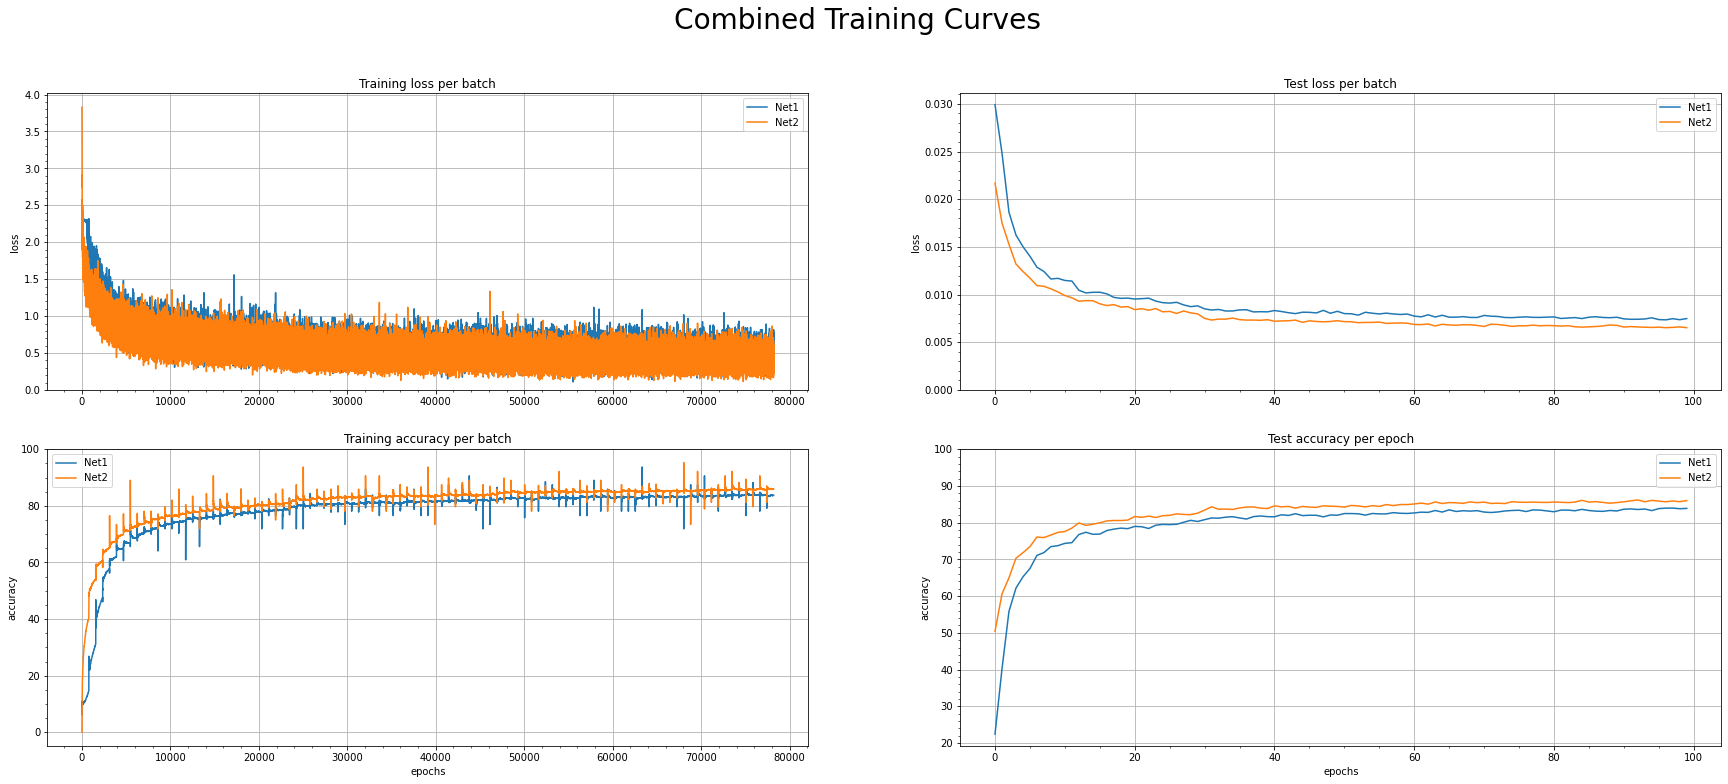

In [12]:
training_curves(history)